Here we inspect the suitability of different normalization methods. To account for sequencing depth, we have to perform sample-wise scaling. To make features have similar importance, we have to perform feature-wise scaling. For sample-wise scaling, popular methods include global normalization (such as rpm counts), but in this thesis we use scaling according to a houskeeping gene, such as mir-16-5p (taken from literature and inspected in the notebook: masters_project_data_and_notebooks/Notebooks/pre_processing_methods/TCGA_TGCT_different_normalizations_and_filterings.ipynb). For sample-wise scaling, common methods include Z-normalzation, log-normalization.

In [ ]:
import sys
!git clone https://github.com/Ignas12345/masters_project_helper_functions.git
sys.path.append('/content/masters_project_helper_functions')

Cloning into 'masters_project_helper_functions'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 31 (delta 10), reused 25 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (31/31), 13.57 KiB | 2.71 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [ ]:
import pandas as pd
import numpy as np
from IPython.display import display

from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn._config import set_config

import masters_project_helper_functions.utils as utils
import masters_project_helper_functions.plotting as plotting
import masters_project_helper_functions.feature_selection as feature_selection

from masters_project_helper_functions.normalization_methods import normalize_by_housekeeping_list

Define functions for this notebook:

In [ ]:
def initial_pre_processing_pipeline(df):
    collapsed = utils.collapse_columns_by_string(df)
    filtered = utils.filter_by_suffix(
        collapsed,
        suffix_to_not_include=('unannotated', 'precursor', 'stemloop')
    )
    return filtered

In [ ]:
def feature_filtering_by_class_means(df_to_use, class1_samples, class2_samples, class1_name = '1', class2_name = '2', threshold_to_keep = 45):
    '''paprasta funkcija, kuri atlieka bruozu filtravima pagal meginius ir ju klases. (should be used with rpm data) - thereshold_to_keep = 50 buvo paimta iš TCGA tyrimo'''
    # Extract expression data for the two classs
    data1 = df_to_use.loc[class1_samples].copy()
    data2 = df_to_use.loc[class2_samples].copy()

    #By default leave only the features that reach 50 (45 for safety) RPM in any of the classes
    features_to_keep_1 = [feature for feature in data1.columns if data1[feature].mean() >= threshold_to_keep]
    features_to_keep_2 = [feature for feature in data2.columns if data2[feature].mean() >= threshold_to_keep]
    features_to_keep = list(set(features_to_keep_1).union(set(features_to_keep_2)))

    print('number of features expressed (in mean) above ' + str(threshold_to_keep)+' in class ' +class1_name+ ': ' + str(len(features_to_keep_1)))
    print('number of features expressed (in mean) above ' + str(threshold_to_keep)+' in class ' +class2_name+ ': ' + str(len(features_to_keep_2)))
    print('number of features in kept across both classes: ' + str(len(features_to_keep)))

    return features_to_keep

In [ ]:
def filter_low_expression_features(data, min_count=5, min_observations=3):
    """
    Filters out features (columns) that are weakly expressed across observations (should be used with raw counts data).

    Parameters:
    - data (pd.DataFrame): Rows are observations, columns are features (e.g., raw counts).
    - min_count (int): Minimum value a feature must have to be considered "expressed".
    - min_observations (int): Minimum number of observations where a feature must be expressed.

    Returns:
    - pd.DataFrame: Filtered DataFrame with only sufficiently expressed features.
    """
    data = data.copy()
    expressed_mask = (data >= min_count)
    keep_features = expressed_mask.sum(axis=0) >= min_observations
    print('Number of features kept: ' + str(keep_features.sum()))
    return keep_features[keep_features].index

import pandas as pd

def keep_top_n_features_by_mean(df, n):

    col_means = df.mean()
    top_n_columns = col_means.nlargest(n).index

    return top_n_columns

In [ ]:
def prepare_dfs(sample_label_dict = None, possible_dfs = {}):
  if sample_label_dict is not None:
    group_labels = [label for label in list(set(sample_label_dict.values())) if label != 'unused']
    group_1_samples = [sample for sample, label in sample_label_dict.items() if label == group_labels[0]]
    group_2_samples = [sample for sample, label in sample_label_dict.items() if label == group_labels[1]]

    print('Running supervised filtering by raw count threshold:' )
    features_after_sup_filtering_by_class_means = feature_filtering_by_class_means(TCGA_mirna_rpm_counts.copy(), group_1_samples, group_2_samples)

    possible_dfs['sup filtered raw counts'] = TCGA_mirna_raw_counts[features_after_sup_filtering_by_class_means].copy()
    possible_dfs['sup filtered rpm counts'] = TCGA_mirna_rpm[features_after_sup_filtering_by_class_means].copy()
    possible_dfs['sup filtered mir_16_5p_scaled_mirna_counts'] = mir_16_5p_scaled_mirna_counts[features_after_sup_filtering_by_class_means].copy()

  #print names of possible dfs together with their shapes:
  for df_name in possible_dfs:
    print(df_name + ' has shape: ' + str(possible_dfs[df_name].shape))

  return possible_dfs

In [ ]:
def identity_normalization(df):
    return df

def log_normalization(df, mean_center = True):
    norm_data =  np.log2(df + 1)
    if mean_center:
        return norm_data - norm_data.mean()
    else:
        return norm_data

def log_normalization_followed_by_z_normalization(df):
    return z_normalization(log_normalization(df))

def log_normalization_followed_by_modified_z_normalization(df):
    original_mean = df.mean()
    return z_normalization(log_normalization(df)) * np.log(original_mean + 1)

def z_normalization(df, use_std = True):
  if use_std:
    return (df - df.mean()) / (df.std() + 1e-6)
  else:
    return (df - df.mean())

def modified_z_normalization(df):
  '''
  Same as Z-normalization, but features on bigger scales get more importance
  '''
  return ((df - df.mean()) / (df.std() + 1e-6)) * np.log(df.mean() + 1)

normalization_methods = {
    'identity': identity_normalization,
    'z_normalization': z_normalization,
    'modified_z_normalization': modified_z_normalization,
    'log_normalization': log_normalization,
    'log_normalization_followed_by_z_normalization': log_normalization_followed_by_z_normalization,
    'log_normalization_followed_by_modified_z_normalization': log_normalization_followed_by_modified_z_normalization
}


In [ ]:
def perform_normalization_and_pca(df, normalization_method, explained_var_threshold = 0.90):
  df = df.copy()
  df_to_transform = normalization_method(df)
  pca = PCA()
  pca_data = pca.fit_transform(df_to_transform)
  n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= explained_var_threshold) + 1
  print(str(n_components) + ' components explain ' + str(explained_var_threshold * 100) + '% of the variance')
  pca = PCA(n_components=n_components)
  pca_data = pca.fit_transform(df_to_transform)
  return pca, pca_data

In [ ]:
def perform_DE_and_display(reduced_data, group_1_samples, group_2_samples, sample_label_dict, label_color_dict, df_name = '', normalization_method_name = '', reduction_name = '', experiment_name = ''):
    print('running ' + reduction_name + ' on ' + df_name + ' using normalization ' + normalization_method_name + ' and labels from ' + experiment_name)

    #shift each pca component so that minimum value is 0:
    shifted_reduced_data = reduced_data - reduced_data.min(axis=0)

    reduced_DE_results = feature_selection.perform_DE_test(shifted_reduced_data, group_1_samples, group_2_samples)
    #display(reduced_DE_results)
    top_DE_features = feature_selection.get_top_DE_features(reduced_DE_results, ignore_p_value = True)
    #remove duplicate indices of top_DE_feature:
    top_DE_features = top_DE_features[~top_DE_features.index.duplicated(keep='first')].copy()
    #display(top_DE_features)
    #sort top DE features by abs(Fold Change)
    top_DE_features = top_DE_features.sort_values(by='Fold Change', key=abs, ascending=False)
    top_DE_features.set_index('feature', inplace=True)
    display(top_DE_features)
    #plot top 5 DE features + features that have significant = True:
    for i,feature in enumerate(top_DE_features.index):
      if top_DE_features.loc[feature, 'significant'] == True:
        print('plotting significant feature: ' + str(feature))
        print('feature rank is ' + str(i))
        plotting.plot_single_feature(reduced_data, feature, sample_label_dict = sample_label_dict, label_color_dict = label_color_dict ,title = reduction_name + ' on ' + df_name + ' using ' + normalization_method_name, ylim = [-1,1])
      elif top_DE_features.index.get_loc(feature) < 5:
        print('plotting feature: ' + str(feature))
        print('feature rank is ' + str(i))
        plotting.plot_single_feature(reduced_data, feature, sample_label_dict = sample_label_dict, label_color_dict=label_color_dict, title = reduction_name + ' on ' + df_name + ' using ' + normalization_method_name, ylim = [-1,1])

In [ ]:
def run_scalings_pca_ica_and_DE(df, normalization_methods, sample_label_dict, explained_var_threshold = 0.90, df_name = '', experiment_name = ''):
  df = df.copy()
  group_labels = [label for label in list(set(sample_label_dict.values())) if label != 'unused']
  smaller_group_label = min(group_labels, key=lambda x: len([sample for sample, label in sample_label_dict.items() if label == x]))
  larger_group_label = max(group_labels, key=lambda x: len([sample for sample, label in sample_label_dict.items() if label == x]))
  group_1_samples = [sample for sample, label in sample_label_dict.items() if label == smaller_group_label]
  group_2_samples = [sample for sample, label in sample_label_dict.items() if label == larger_group_label]
  label_color_dict = {larger_group_label: 'red', 'unused': 'orange', smaller_group_label: 'blue'}



  for normalization_method_name in normalization_methods:
    print('running normalization on df: ' + normalization_method_name + ' on ' + df_name)
    method = normalization_methods[normalization_method_name]
    pca, pca_data = perform_normalization_and_pca(df, method)
    #display(pca_data)
    #shift each pca component so that minimum value is 0:
    perform_DE_and_display(pca_data, group_1_samples, group_2_samples, sample_label_dict, label_color_dict, df_name = df_name, normalization_method_name = normalization_method_name, reduction_name='PCA', experiment_name = experiment_name)

    ica = FastICA()
    ica_data = ica.fit_transform(pca_data)
    perform_DE_and_display(ica_data, group_1_samples, group_2_samples, sample_label_dict, label_color_dict, df_name = df_name, normalization_method_name = normalization_method_name, reduction_name='ICA', experiment_name = experiment_name)

Load data

In [ ]:
url_TCGA_mirna_raw_counts = "https://raw.githubusercontent.com/Ignas12345/masters_project_data_and_notebooks/refs/heads/main/Data/expression_values/TCGA_TGCT_mirna_isoform_data_raw_counts.csv"
TCGA_mirna_raw_counts = utils.format_data_frame(url_TCGA_mirna_raw_counts, sep = ';', transpose = True)
url_TCGA_mirna_rpm = "https://raw.githubusercontent.com/Ignas12345/masters_project_data_and_notebooks/refs/heads/main/Data/expression_values/TCGA_TGCT_mirna_isoform_data_rpm.csv"
TCGA_mirna_rpm = utils.format_data_frame(url_TCGA_mirna_rpm, sep = ';', decimal = ',', transpose = True)
TCGA_TGCT_divisions_by_experiment_url = "https://raw.githubusercontent.com/Ignas12345/masters_project_data_and_notebooks/refs/heads/main/Data/sample_annotations/TCGA_TGCT_divisions_by_experiment.csv"
TCGA_TGCT_divisions_by_experiment = pd.read_csv(TCGA_TGCT_divisions_by_experiment_url, index_col=0)
TCGA_mirna_raw_counts = TCGA_mirna_raw_counts.loc[TCGA_TGCT_divisions_by_experiment.index].copy()
TCGA_mirna_rpm_counts = TCGA_mirna_rpm.loc[TCGA_TGCT_divisions_by_experiment.index].copy()

set_config(transform_output='pandas')

reading df from url: https://raw.githubusercontent.com/Ignas12345/masters_project_data_and_notebooks/refs/heads/main/Data/expression_values/TCGA_TGCT_mirna_isoform_data_raw_counts.csv
nan values filled with 0
column names truncated using: slice(None, 15, None)
df transposed
final shape of df: (156, 3689)

reading df from url: https://raw.githubusercontent.com/Ignas12345/masters_project_data_and_notebooks/refs/heads/main/Data/expression_values/TCGA_TGCT_mirna_isoform_data_rpm.csv
nan values filled with 0
column names truncated using: slice(None, 15, None)
df transposed
final shape of df: (156, 3689)



In [ ]:
label_color_dict = {'seminoma': 'red', 'embryonal': 'yellow', 'embryonal dominant': 'orange',
                    'non-seminoma- mixed (no dominant component)': 'gray', 'mature teratoma dominant': 'mediumblue',
                    'mature teratoma': 'darkblue', 'immature teratoma dominant' : 'blue',
                    'yolk sac dominant': 'green', 'yolk sac': 'darkgreen'}

Initial pre-processing (collapse by summing counts from different locations, remove pre-cursors, stem-loops.)

In [ ]:
TCGA_mirna_raw_counts = initial_pre_processing_pipeline(TCGA_mirna_raw_counts)
TCGA_mirna_rpm_counts = initial_pre_processing_pipeline(TCGA_mirna_rpm_counts)

mir_16_5p_scaled_mirna_counts = normalize_by_housekeeping_list(
    TCGA_mirna_raw_counts.copy(),
    housekeeping_list=['hsa-mir-16-1, mature,MIMAT0000069', ]
  )

initial shape: (137, 3689)
shape after collapsing: (137, 2212)
initial shape: (137, 2212)
shape after filtering: (137, 2191)
initial shape: (137, 3689)
shape after collapsing: (137, 2212)
initial shape: (137, 2212)
shape after filtering: (137, 2191)


In [ ]:
features_after_unsup_filtering_by_low_expression = filter_low_expression_features(TCGA_mirna_raw_counts.copy())

Number of features kept: 1080


In [ ]:
top_400_features_after_unsup_filtering_by_mean = keep_top_n_features_by_mean(TCGA_mirna_rpm_counts, 400)
#sum(top_400_features_after_unsup_filtering_by_mean == 'hsa-mir-371a, mature,MIMAT0000723')

In [ ]:
TCGA_mirna_raw_counts.columns[TCGA_mirna_raw_counts.columns.str.startswith('hsa-mir-371')]

Index(['hsa-mir-3714, mature,MIMAT0018165',
       'hsa-mir-371a, mature,MIMAT0000723',
       'hsa-mir-371a, mature,MIMAT0004687',
       'hsa-mir-371b, mature,MIMAT0019892',
       'hsa-mir-371b, mature,MIMAT0019893'],
      dtype='object')

In [ ]:
experiment_names = TCGA_TGCT_divisions_by_experiment.keys()
experiment_names

Index(['seminoma_vs_non_seminoma', 'seminoma_vs_embryonal',
       'embryonal_vs_non_embryonal_non_seminoma', 'teratoma_vs_non_teratoma',
       'KIT_wildtype_vs_mutated_seminoma',
       'teratoma_present_vs_teratoma_absent', 'multiclass_label'],
      dtype='object')

There are a lot of plots below, but most of them are not useful. They can be used as a look-up tool if any particular pre-processing method would need to be investigated by a pca/ica plot. The main take-aways are that

1)ICA often components fail to capture the signal for (except, for example, for seminoma vs. non-seminoma/embryonal where supervised feature filtering + log-normalization + z-normalization gives a good separation, which is worth investigating)

2)PCA can capture that with some of the main components

3)PCA explains a lot of the varience with very few components if z-normalization is not used which indicated that some components dominate in expression. If z-normaliztion is used, then need much more components (not much correlation among the mirnas)

4)Main differences are between z-normalization and log-normalization (at first sight). Another thing to keep in mind is that scaling by mir-16-5p leads to similar results as global normalization/no sample-wise normalization

The pipeline for normalizations follows such an outline more or less

1) Sample_wise_scaling (such as RPM or scaling all features by the expression of a houskeeping gene)

2) Feature_wise_scaling (such as Z-normalization)

3) Perform PCA/ICA and get the best separating dimensions as an estimate of signal

First compare PCA plots without division according to experiment:

In [ ]:
possible_dfs = {'raw counts': TCGA_mirna_raw_counts.copy(),
                'unsup filtered raw counts by min expression (>5 raw counts in at least 3 samples)': TCGA_mirna_raw_counts[features_after_unsup_filtering_by_low_expression].copy(),
                'unsup filtered raw counts by mean expression (top 400)': TCGA_mirna_raw_counts[top_400_features_after_unsup_filtering_by_mean].copy(),

                'rpm counts': TCGA_mirna_rpm_counts.copy(),
                'unsup filtered rpm counts by min expression': TCGA_mirna_rpm_counts[features_after_unsup_filtering_by_low_expression].copy(),
                'unsup filtered rpm counts by mean expression (top 400)': TCGA_mirna_rpm_counts[top_400_features_after_unsup_filtering_by_mean].copy(),

                'mir_16_5p_scaled_mirna_counts': mir_16_5p_scaled_mirna_counts,
                'unsup filtered mir_16_5p_scaled_mirna_counts by min expression': mir_16_5p_scaled_mirna_counts[features_after_unsup_filtering_by_low_expression].copy(),
                'unsup filtered mir_16_5p_scaled_mirna_counts by mean expression (top 400)' : mir_16_5p_scaled_mirna_counts[top_400_features_after_unsup_filtering_by_mean].copy()}


raw counts has shape: (137, 2191)
unsup filtered raw counts by min expression (>5 raw counts in at least 3 samples) has shape: (137, 1080)
unsup filtered raw counts by mean expression (top 400) has shape: (137, 400)
rpm counts has shape: (137, 2191)
unsup filtered rpm counts by min expression has shape: (137, 1080)
unsup filtered rpm counts by mean expression (top 400) has shape: (137, 400)
mir_16_5p_scaled_mirna_counts has shape: (137, 2191)
unsup filtered mir_16_5p_scaled_mirna_counts by min expression has shape: (137, 1080)
unsup filtered mir_16_5p_scaled_mirna_counts by mean expression (top 400) has shape: (137, 400)
Running normalization and plots on : raw counts
Running identity on raw counts
5 components explain 90.0% of the variance


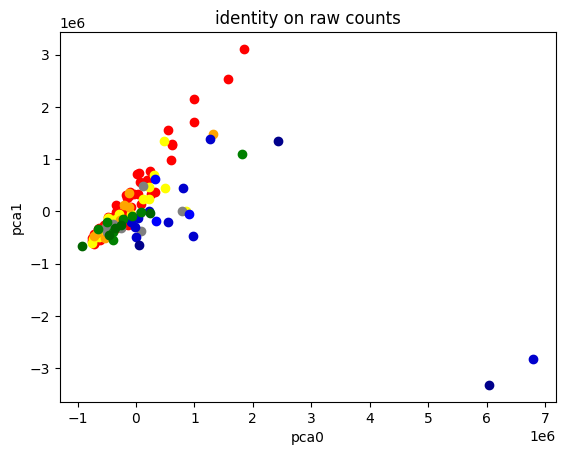

Running z_normalization on raw counts
90 components explain 90.0% of the variance


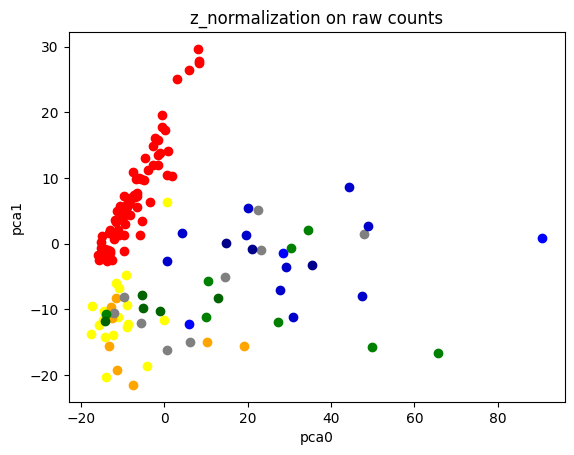

Running modified_z_normalization on raw counts
29 components explain 90.0% of the variance


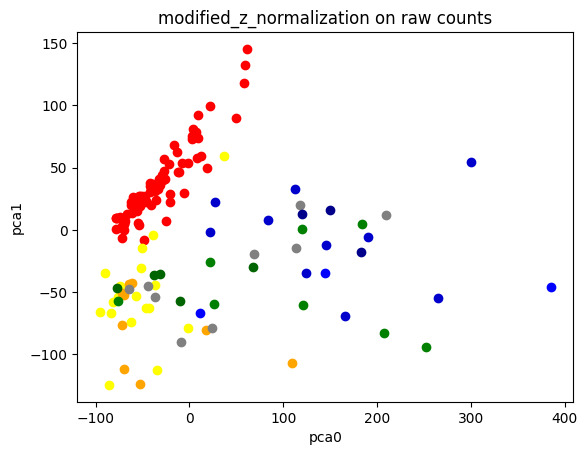

Running log_normalization on raw counts
61 components explain 90.0% of the variance


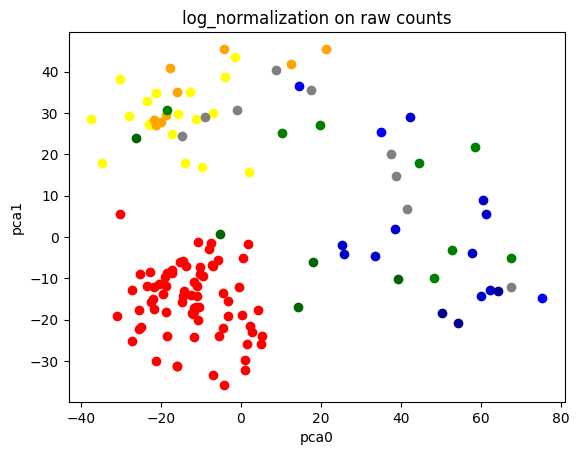

Running log_normalization_followed_by_z_normalization on raw counts
98 components explain 90.0% of the variance


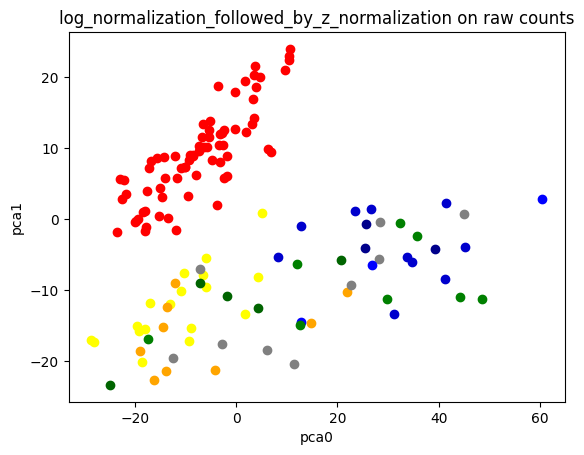

Running log_normalization_followed_by_modified_z_normalization on raw counts
26 components explain 90.0% of the variance


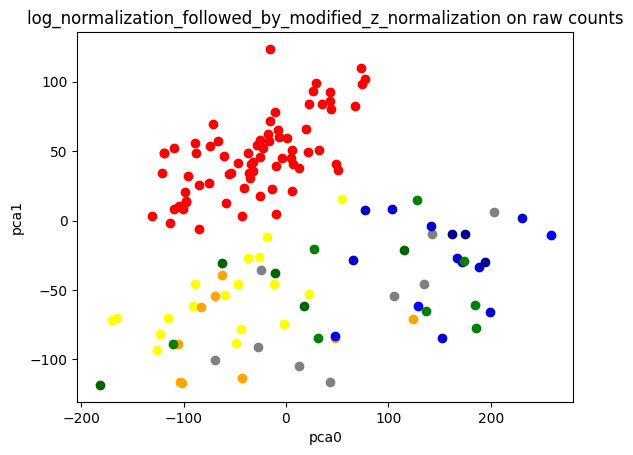

Running normalization and plots on : unsup filtered raw counts by min expression (>5 raw counts in at least 3 samples)
Running identity on unsup filtered raw counts by min expression (>5 raw counts in at least 3 samples)
5 components explain 90.0% of the variance


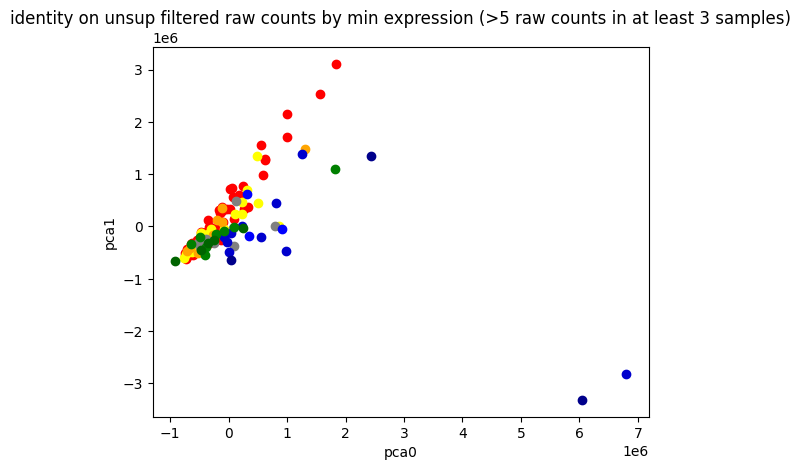

Running z_normalization on unsup filtered raw counts by min expression (>5 raw counts in at least 3 samples)
56 components explain 90.0% of the variance


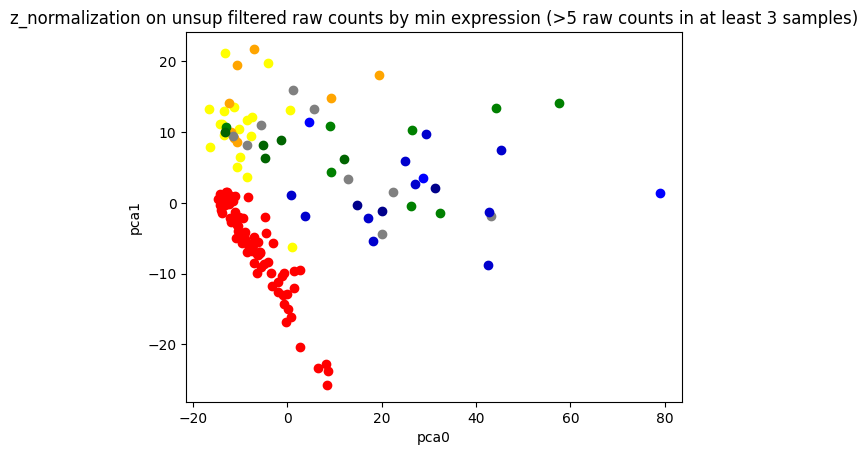

Running modified_z_normalization on unsup filtered raw counts by min expression (>5 raw counts in at least 3 samples)
28 components explain 90.0% of the variance


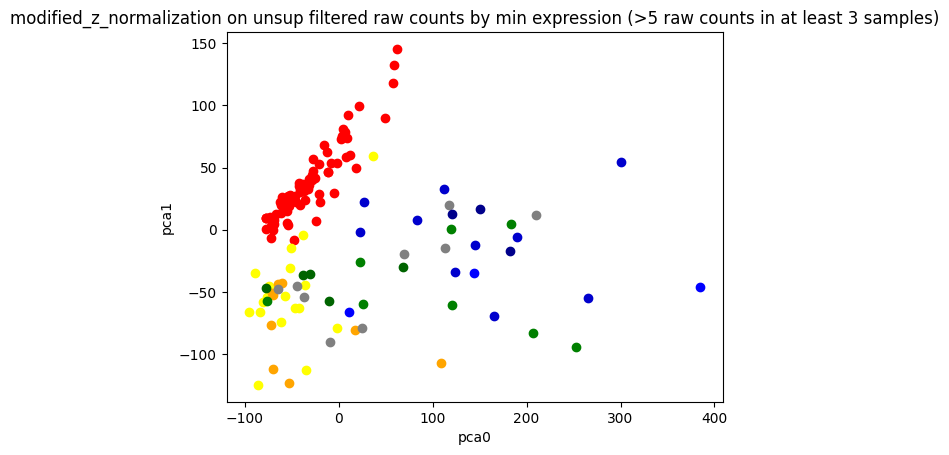

Running log_normalization on unsup filtered raw counts by min expression (>5 raw counts in at least 3 samples)
48 components explain 90.0% of the variance


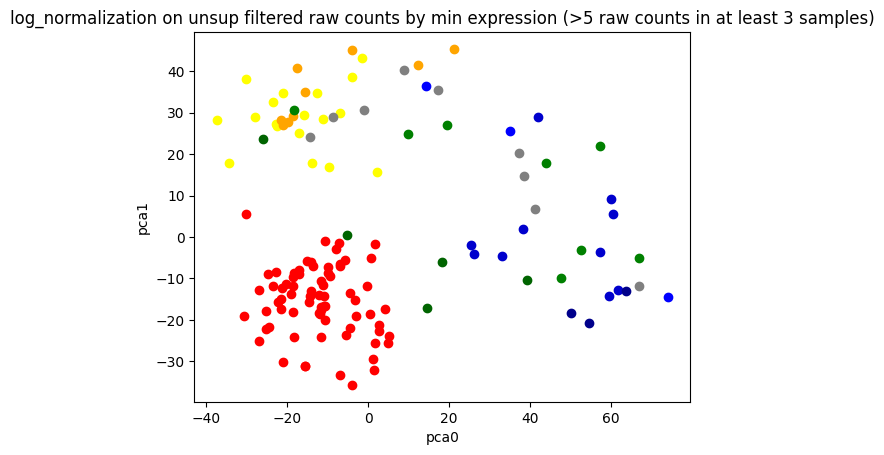

Running log_normalization_followed_by_z_normalization on unsup filtered raw counts by min expression (>5 raw counts in at least 3 samples)
71 components explain 90.0% of the variance


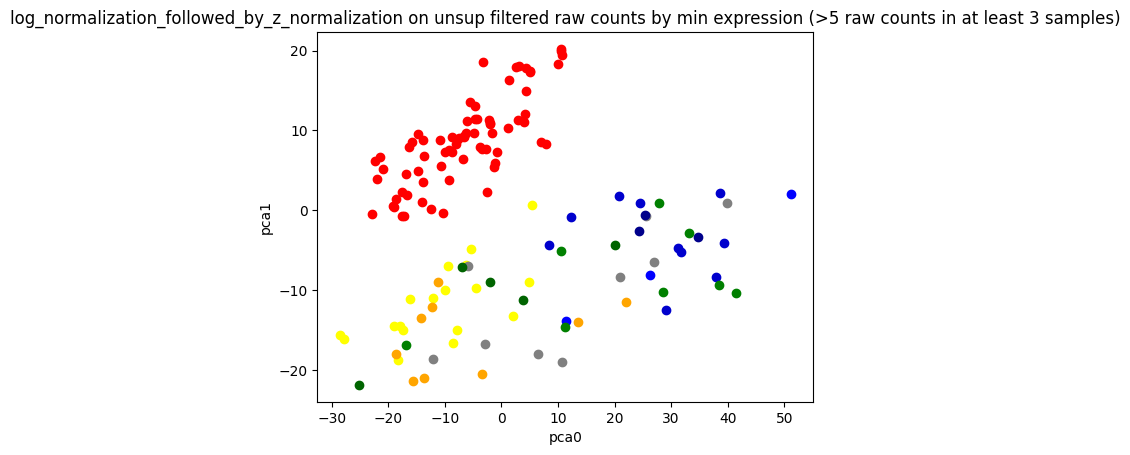

Running log_normalization_followed_by_modified_z_normalization on unsup filtered raw counts by min expression (>5 raw counts in at least 3 samples)
26 components explain 90.0% of the variance


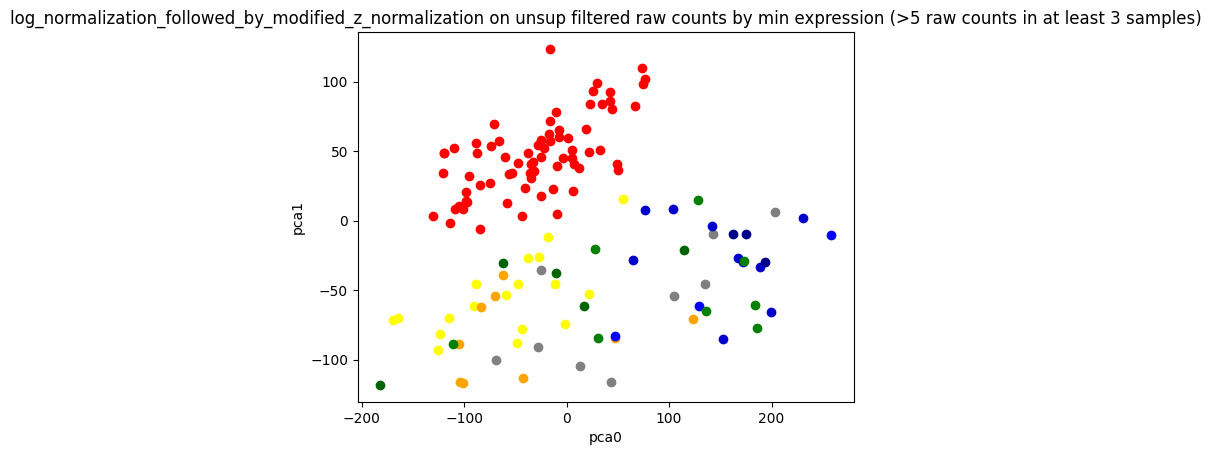

Running normalization and plots on : unsup filtered raw counts by mean expression (top 400)
Running identity on unsup filtered raw counts by mean expression (top 400)
5 components explain 90.0% of the variance


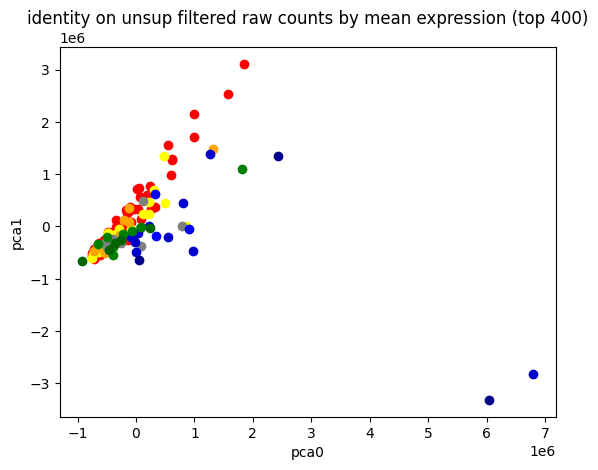

Running z_normalization on unsup filtered raw counts by mean expression (top 400)
25 components explain 90.0% of the variance


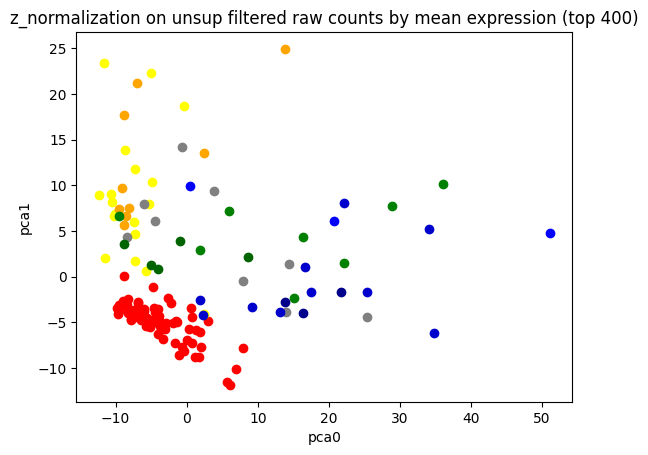

Running modified_z_normalization on unsup filtered raw counts by mean expression (top 400)
23 components explain 90.0% of the variance


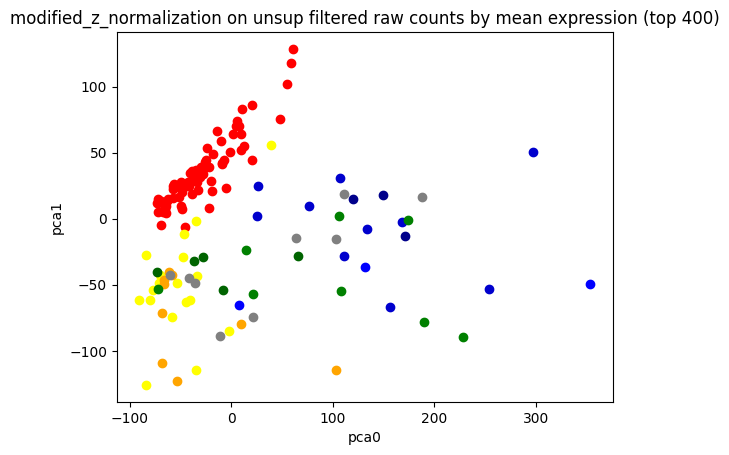

Running log_normalization on unsup filtered raw counts by mean expression (top 400)
15 components explain 90.0% of the variance


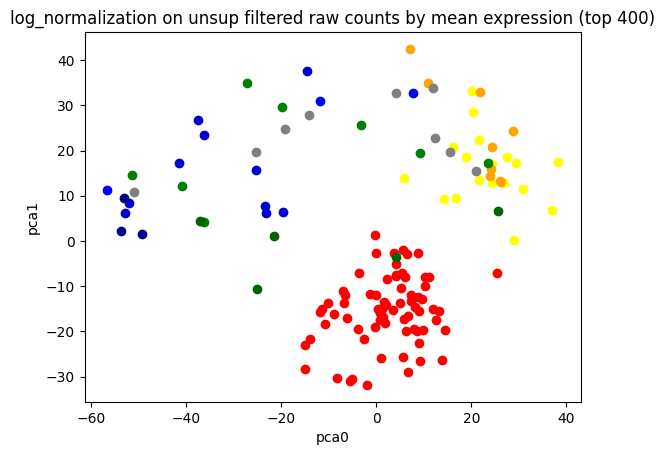

Running log_normalization_followed_by_z_normalization on unsup filtered raw counts by mean expression (top 400)
20 components explain 90.0% of the variance


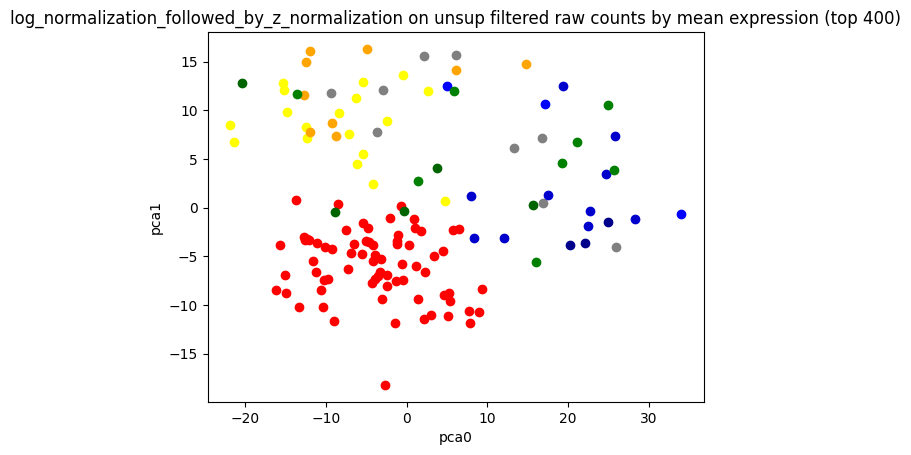

Running log_normalization_followed_by_modified_z_normalization on unsup filtered raw counts by mean expression (top 400)
18 components explain 90.0% of the variance


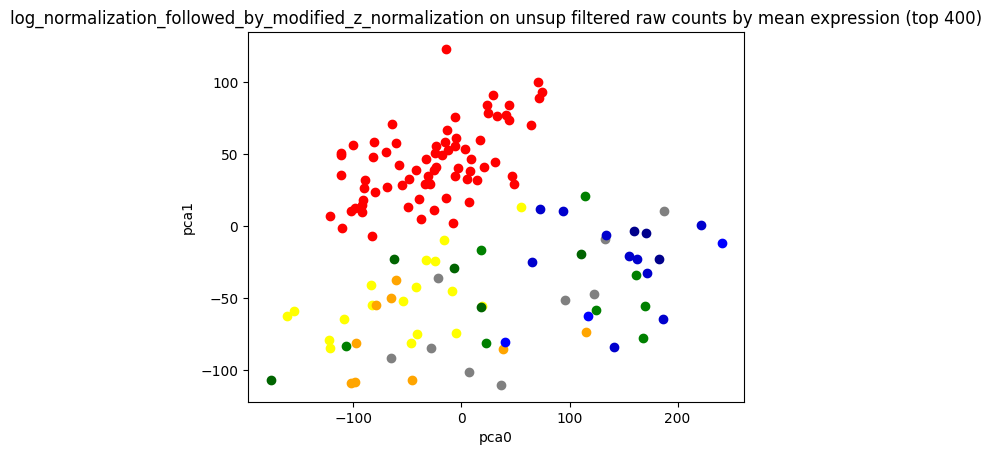

Running normalization and plots on : rpm counts
Running identity on rpm counts
6 components explain 90.0% of the variance


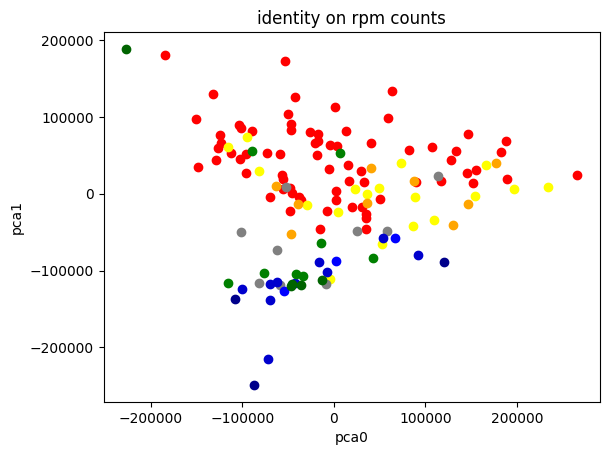

Running z_normalization on rpm counts
99 components explain 90.0% of the variance


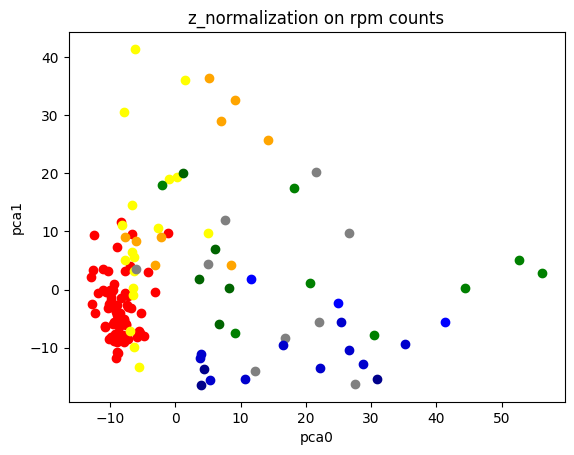

Running modified_z_normalization on rpm counts
36 components explain 90.0% of the variance


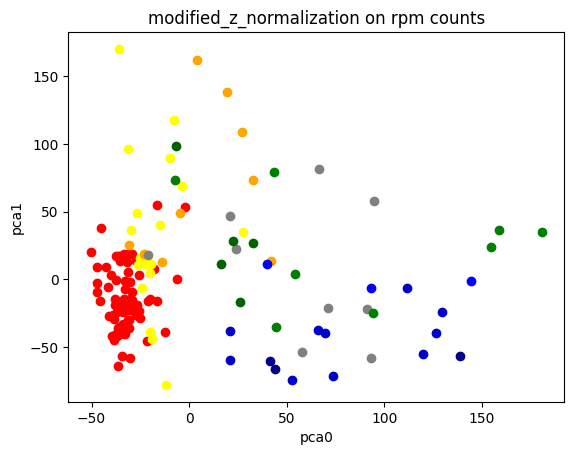

Running log_normalization on rpm counts
35 components explain 90.0% of the variance


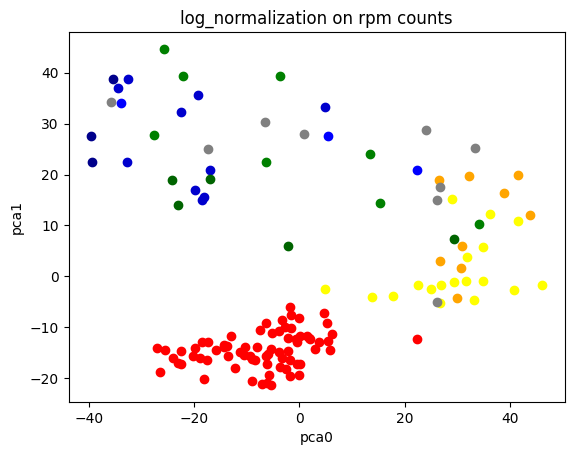

Running log_normalization_followed_by_z_normalization on rpm counts
101 components explain 90.0% of the variance


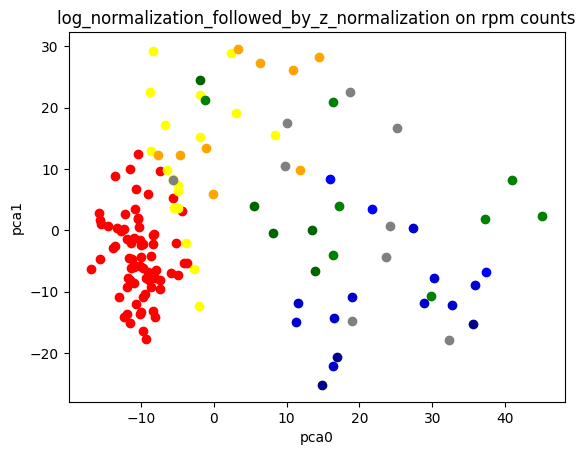

Running log_normalization_followed_by_modified_z_normalization on rpm counts
28 components explain 90.0% of the variance


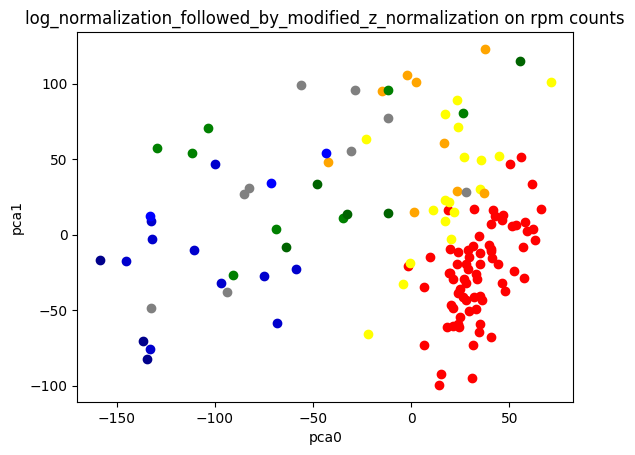

Running normalization and plots on : unsup filtered rpm counts by min expression
Running identity on unsup filtered rpm counts by min expression
6 components explain 90.0% of the variance


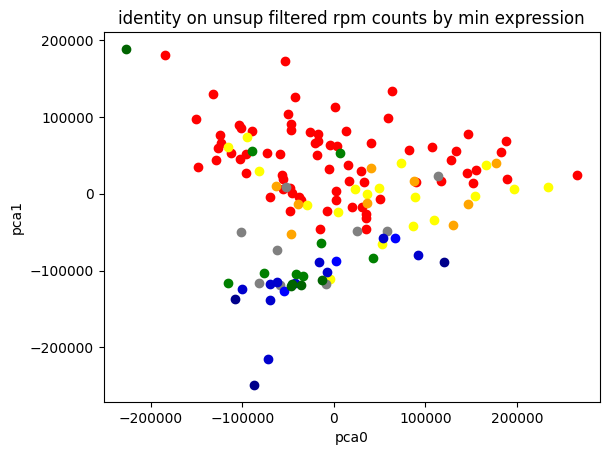

Running z_normalization on unsup filtered rpm counts by min expression
71 components explain 90.0% of the variance


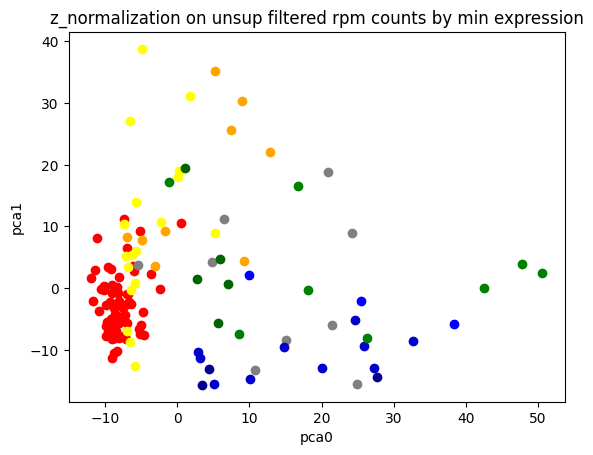

Running modified_z_normalization on unsup filtered rpm counts by min expression
36 components explain 90.0% of the variance


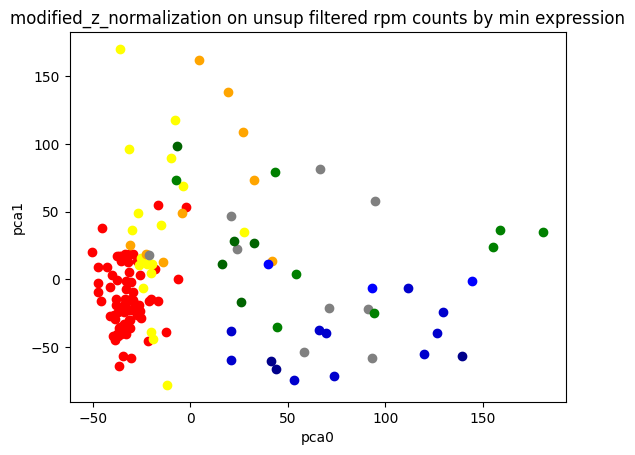

Running log_normalization on unsup filtered rpm counts by min expression
33 components explain 90.0% of the variance


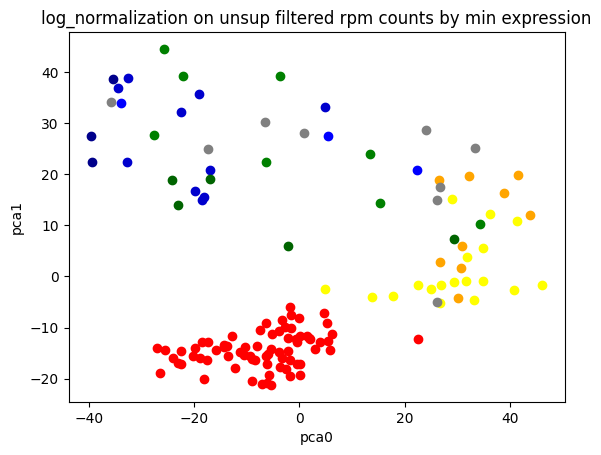

Running log_normalization_followed_by_z_normalization on unsup filtered rpm counts by min expression
74 components explain 90.0% of the variance


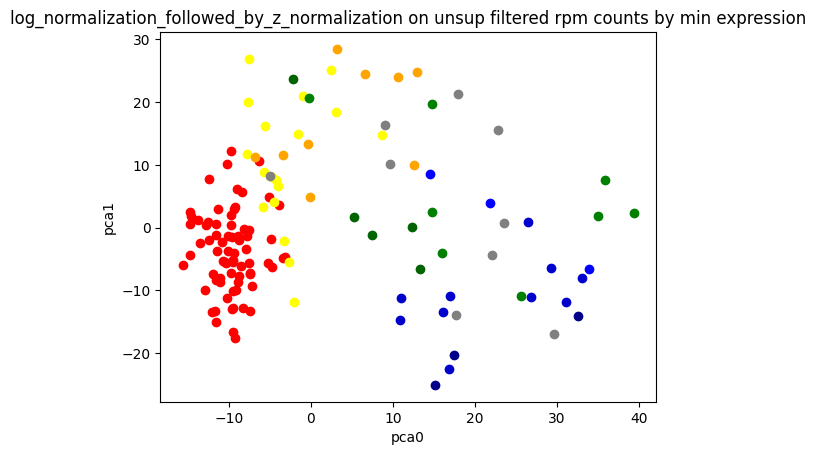

Running log_normalization_followed_by_modified_z_normalization on unsup filtered rpm counts by min expression
28 components explain 90.0% of the variance


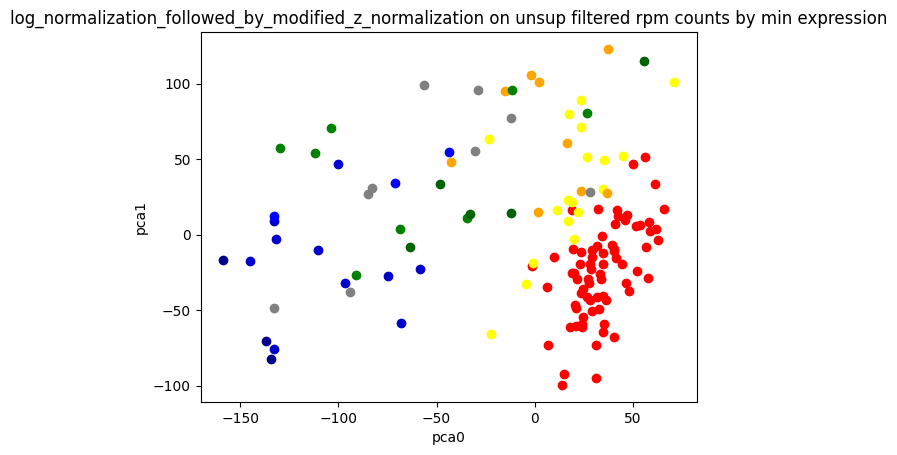

Running normalization and plots on : unsup filtered rpm counts by mean expression (top 400)
Running identity on unsup filtered rpm counts by mean expression (top 400)
6 components explain 90.0% of the variance


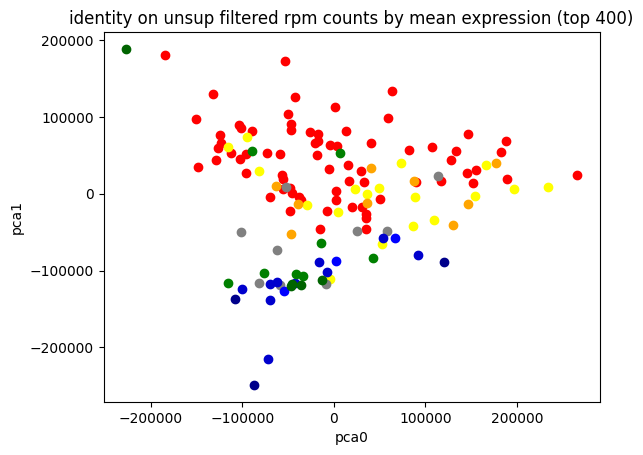

Running z_normalization on unsup filtered rpm counts by mean expression (top 400)
36 components explain 90.0% of the variance


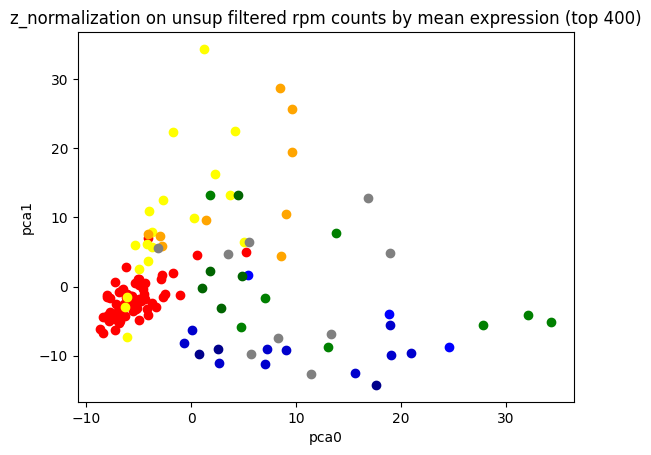

Running modified_z_normalization on unsup filtered rpm counts by mean expression (top 400)
32 components explain 90.0% of the variance


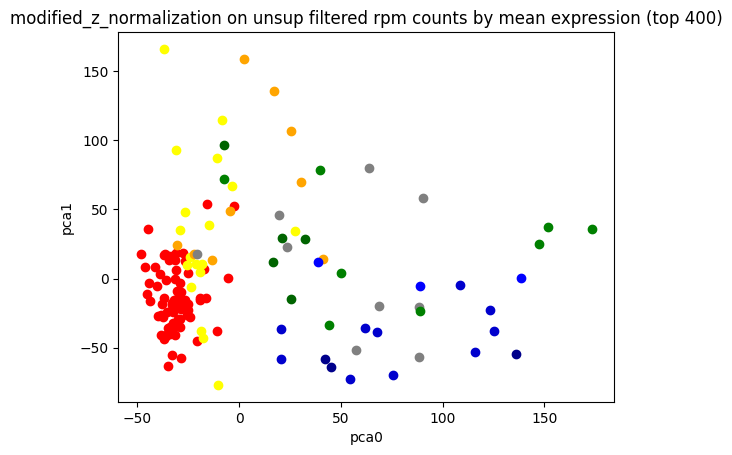

Running log_normalization on unsup filtered rpm counts by mean expression (top 400)
16 components explain 90.0% of the variance


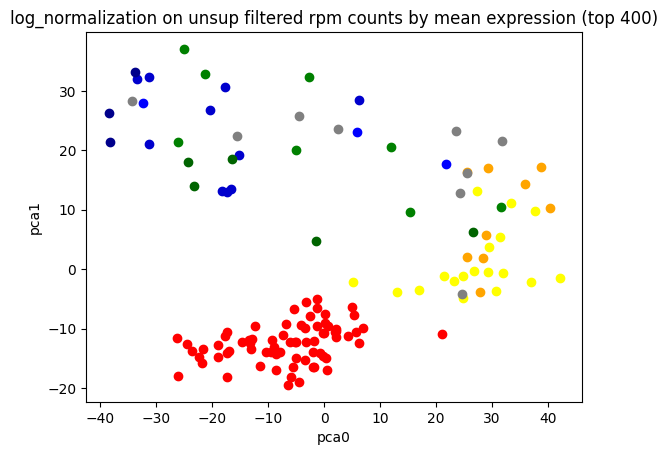

Running log_normalization_followed_by_z_normalization on unsup filtered rpm counts by mean expression (top 400)
28 components explain 90.0% of the variance


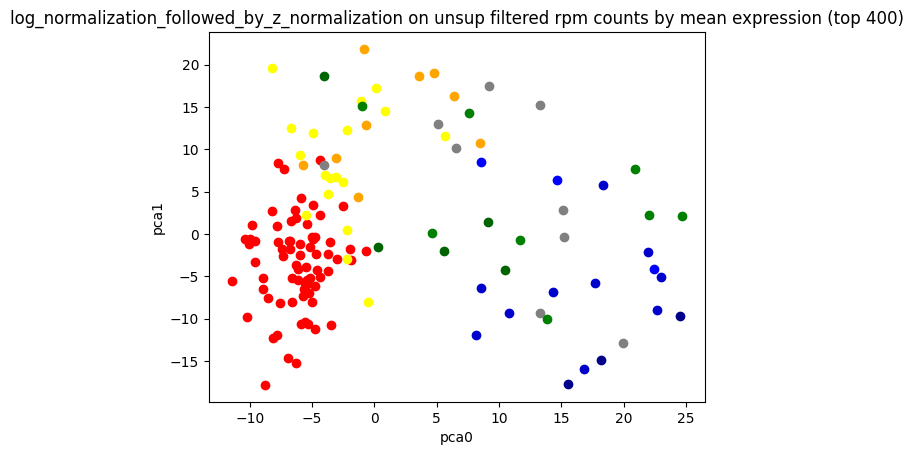

Running log_normalization_followed_by_modified_z_normalization on unsup filtered rpm counts by mean expression (top 400)
24 components explain 90.0% of the variance


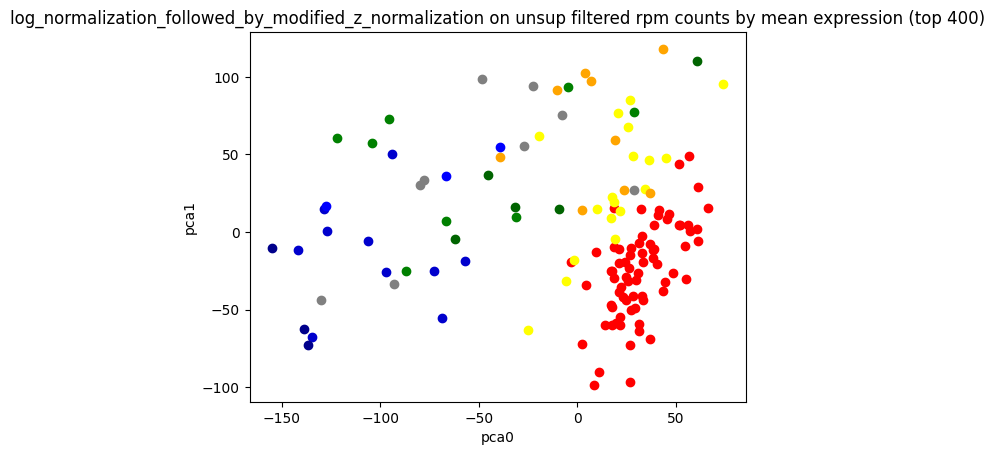

Running normalization and plots on : mir_16_5p_scaled_mirna_counts
Running identity on mir_16_5p_scaled_mirna_counts
5 components explain 90.0% of the variance


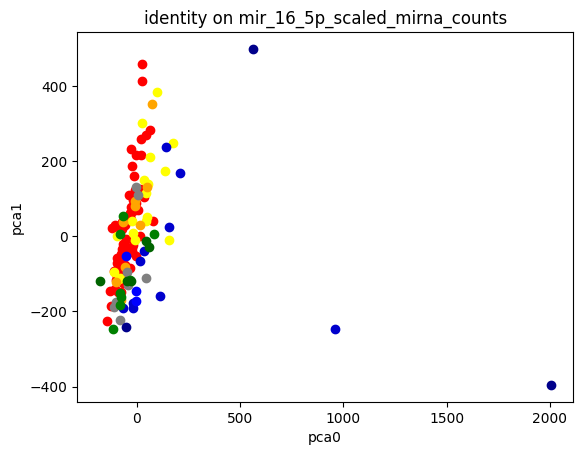

Running z_normalization on mir_16_5p_scaled_mirna_counts
94 components explain 90.0% of the variance


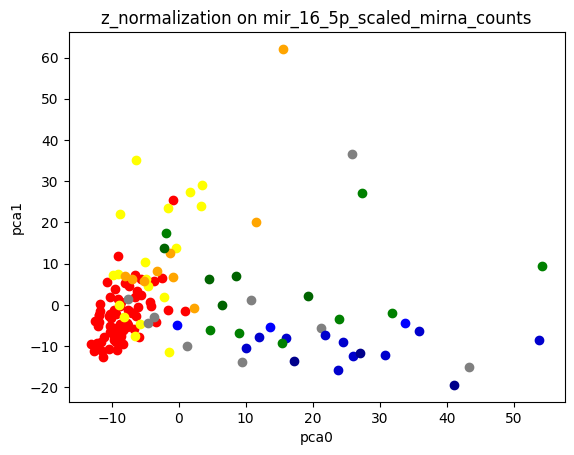

Running modified_z_normalization on mir_16_5p_scaled_mirna_counts
15 components explain 90.0% of the variance


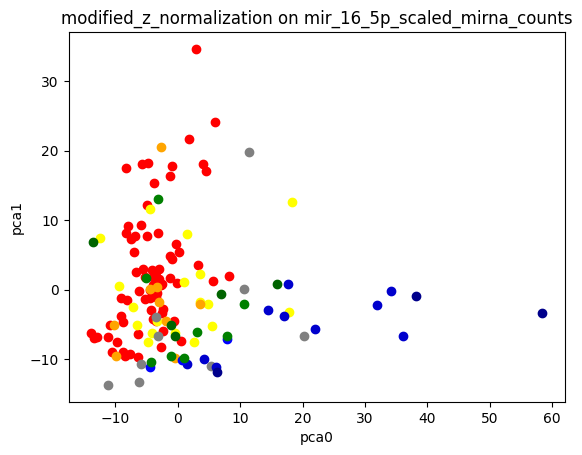

Running log_normalization on mir_16_5p_scaled_mirna_counts
16 components explain 90.0% of the variance


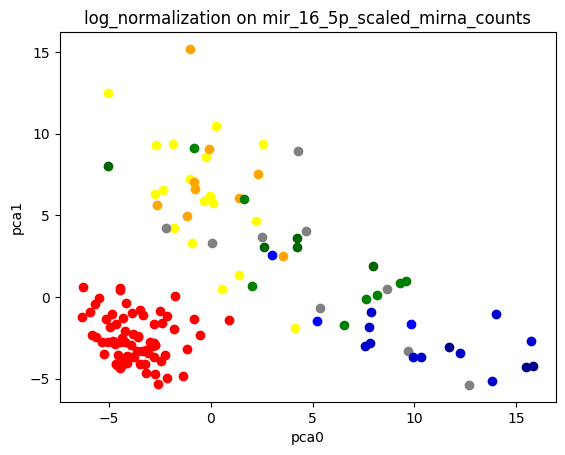

Running log_normalization_followed_by_z_normalization on mir_16_5p_scaled_mirna_counts
95 components explain 90.0% of the variance


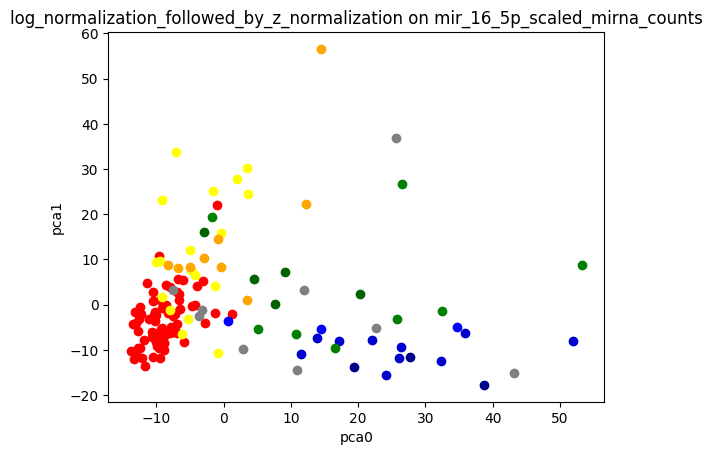

Running log_normalization_followed_by_modified_z_normalization on mir_16_5p_scaled_mirna_counts
13 components explain 90.0% of the variance


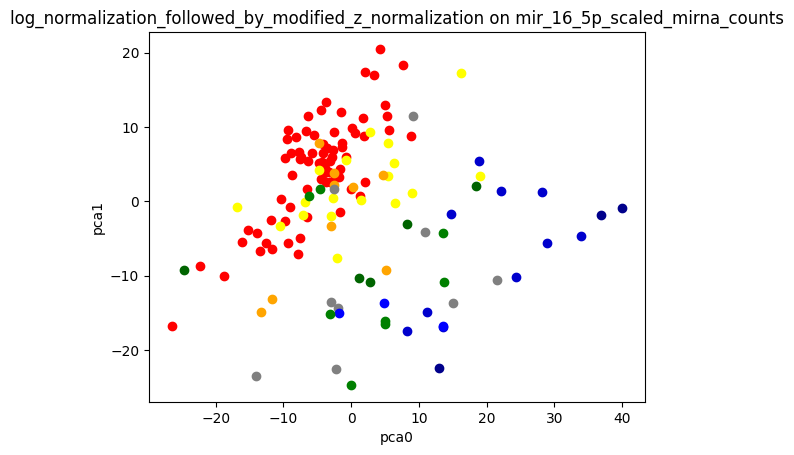

Running normalization and plots on : unsup filtered mir_16_5p_scaled_mirna_counts by min expression
Running identity on unsup filtered mir_16_5p_scaled_mirna_counts by min expression
5 components explain 90.0% of the variance


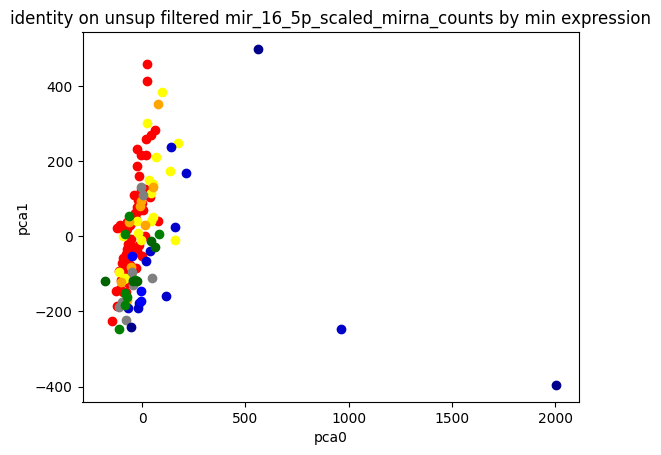

Running z_normalization on unsup filtered mir_16_5p_scaled_mirna_counts by min expression
65 components explain 90.0% of the variance


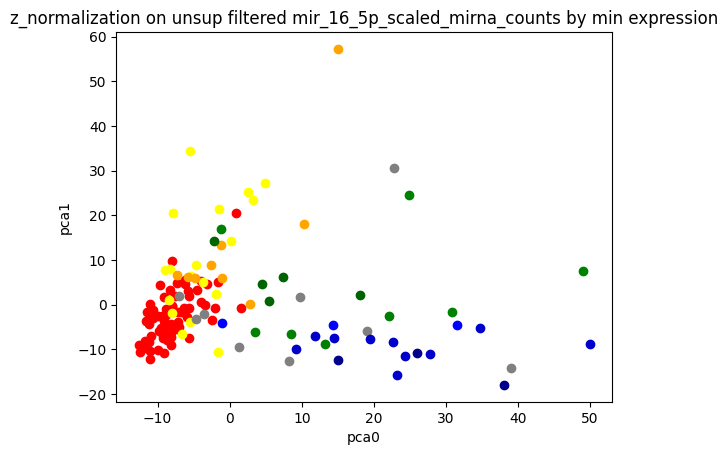

Running modified_z_normalization on unsup filtered mir_16_5p_scaled_mirna_counts by min expression
15 components explain 90.0% of the variance


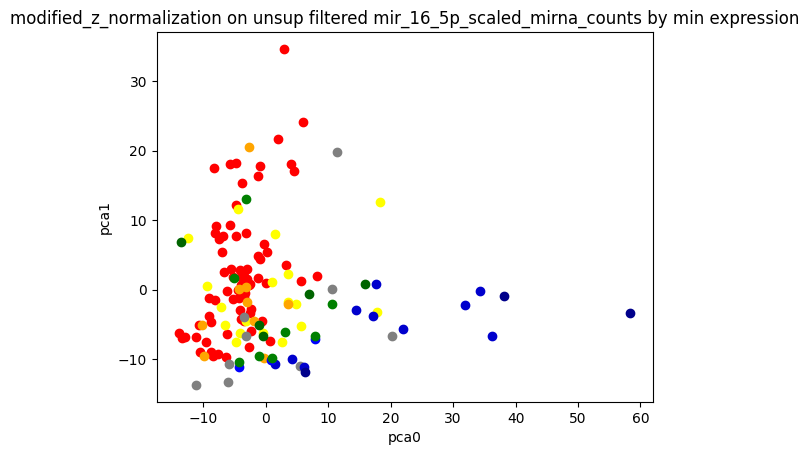

Running log_normalization on unsup filtered mir_16_5p_scaled_mirna_counts by min expression
16 components explain 90.0% of the variance


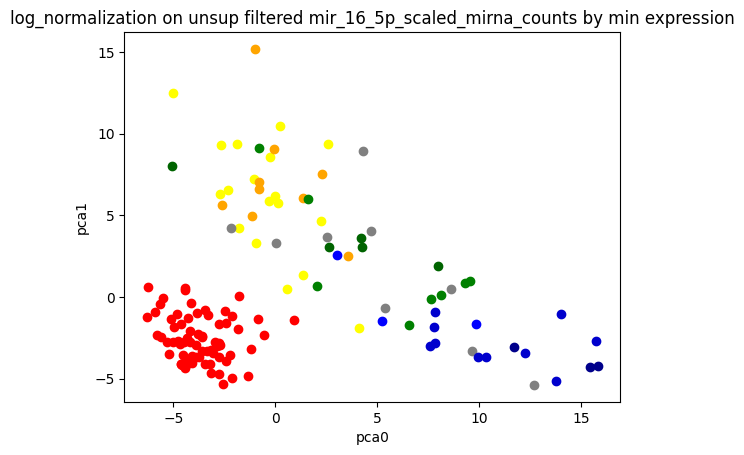

Running log_normalization_followed_by_z_normalization on unsup filtered mir_16_5p_scaled_mirna_counts by min expression
66 components explain 90.0% of the variance


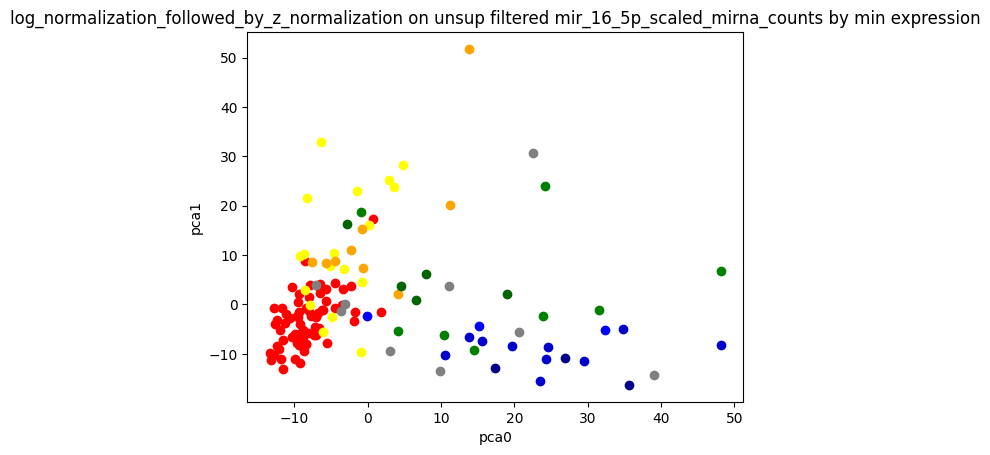

Running log_normalization_followed_by_modified_z_normalization on unsup filtered mir_16_5p_scaled_mirna_counts by min expression
13 components explain 90.0% of the variance


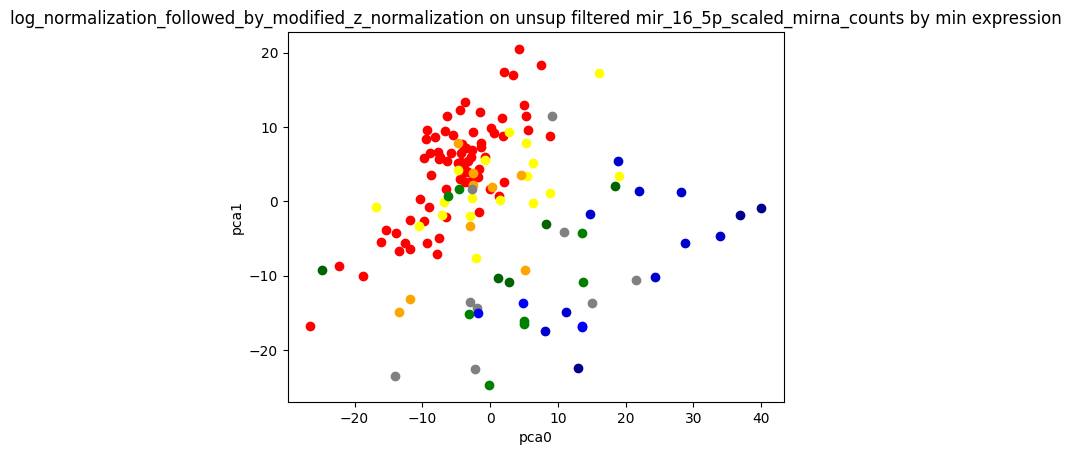

Running normalization and plots on : unsup filtered mir_16_5p_scaled_mirna_counts by mean expression (top 400)
Running identity on unsup filtered mir_16_5p_scaled_mirna_counts by mean expression (top 400)
5 components explain 90.0% of the variance


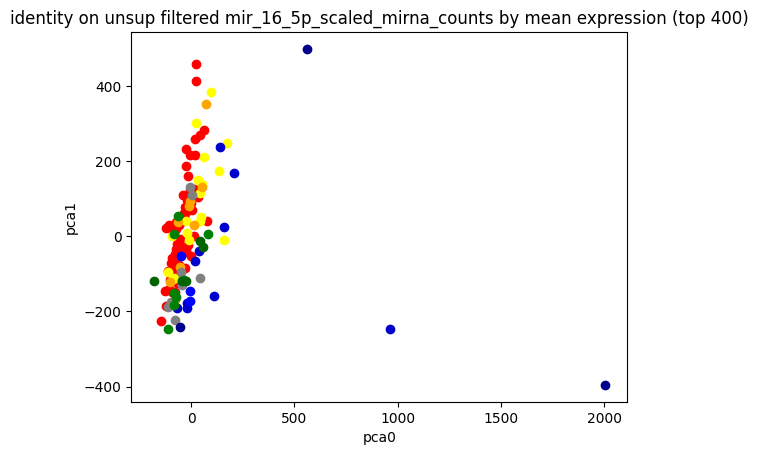

Running z_normalization on unsup filtered mir_16_5p_scaled_mirna_counts by mean expression (top 400)
31 components explain 90.0% of the variance


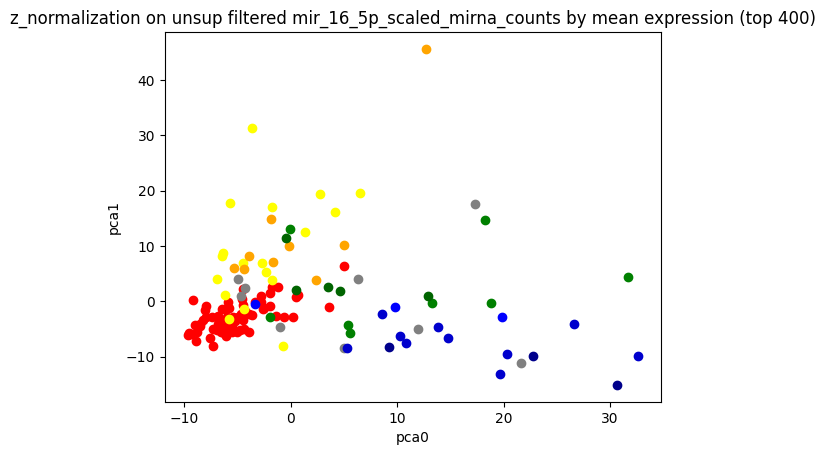

Running modified_z_normalization on unsup filtered mir_16_5p_scaled_mirna_counts by mean expression (top 400)
15 components explain 90.0% of the variance


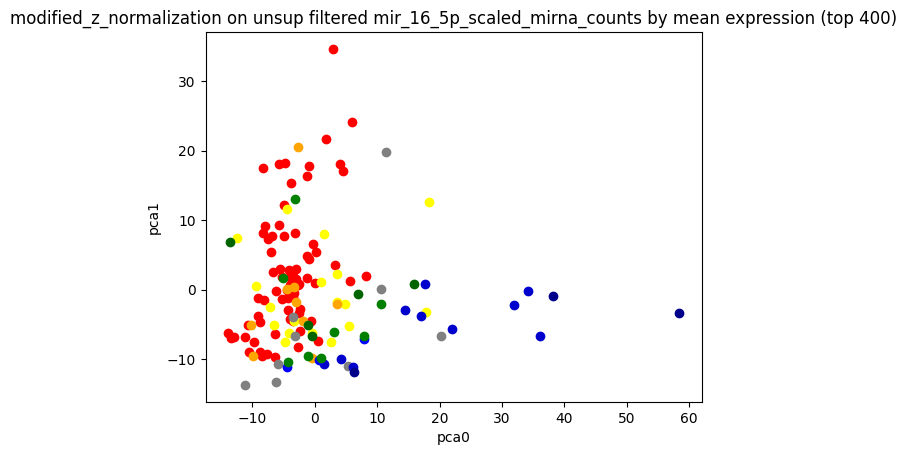

Running log_normalization on unsup filtered mir_16_5p_scaled_mirna_counts by mean expression (top 400)
16 components explain 90.0% of the variance


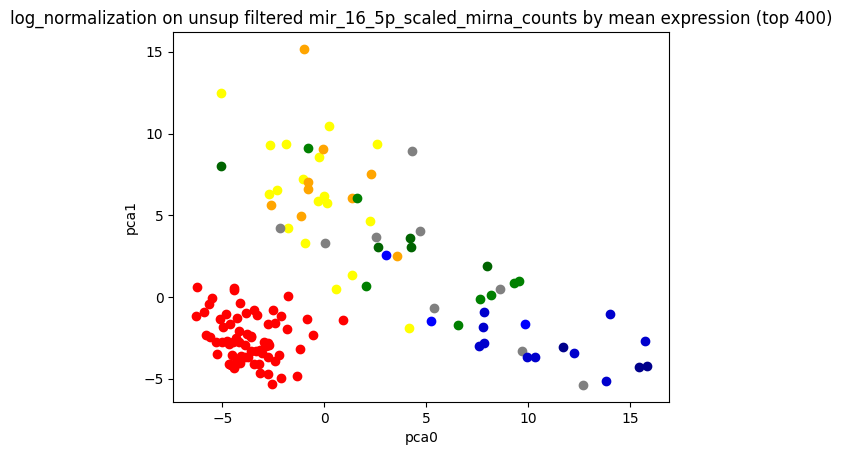

Running log_normalization_followed_by_z_normalization on unsup filtered mir_16_5p_scaled_mirna_counts by mean expression (top 400)
30 components explain 90.0% of the variance


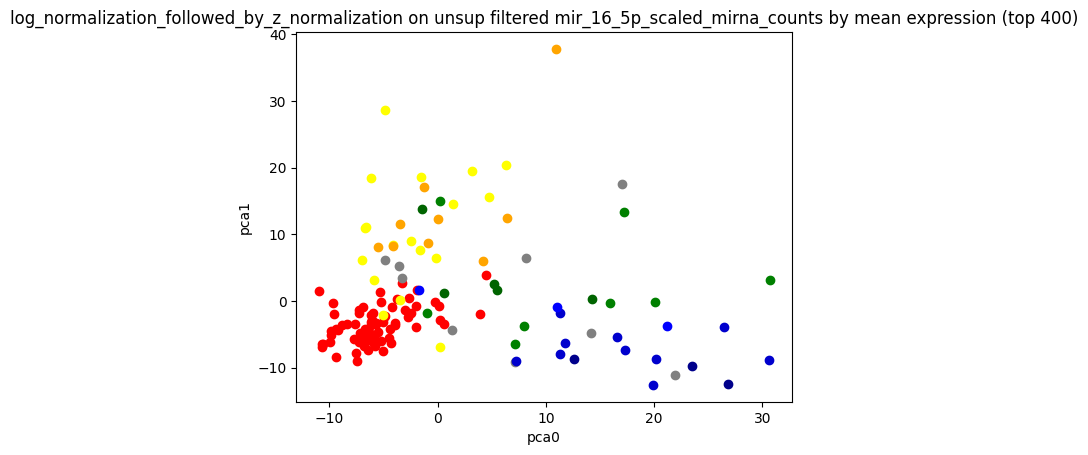

Running log_normalization_followed_by_modified_z_normalization on unsup filtered mir_16_5p_scaled_mirna_counts by mean expression (top 400)
13 components explain 90.0% of the variance


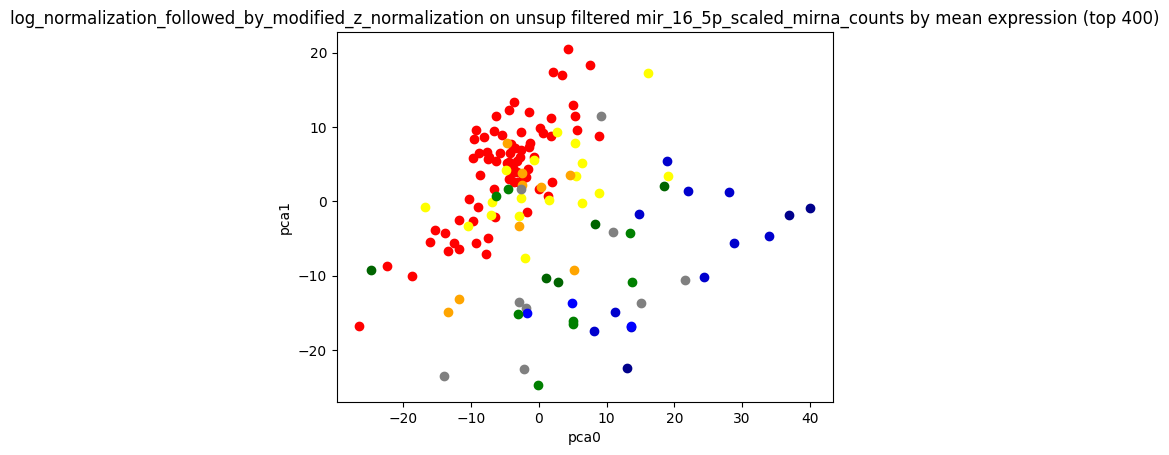

In [ ]:
sample_label_dict = TCGA_TGCT_divisions_by_experiment['multiclass_label'].to_dict()
possible_dfs = prepare_dfs(sample_label_dict = None, possible_dfs = possible_dfs)
for df_name in possible_dfs:
  print('Running normalization and plots on : ' + df_name)
  df = possible_dfs[df_name]
  for normalization_method_name in normalization_methods:
    print('Running ' + normalization_method_name + ' on ' + df_name)
    method = normalization_methods[normalization_method_name]
    pca, pca_data = perform_normalization_and_pca(df, method)
    plotting.plot_two_features(pca_data, 'pca0', 'pca1', sample_label_dict= sample_label_dict, label_color_dict = label_color_dict, show_legend = False, title = normalization_method_name + ' on ' + df_name)

Now perform on individual experiments

In [ ]:
experiment_name = 'teratoma_vs_non_teratoma'
sample_label_dict = TCGA_TGCT_divisions_by_experiment[experiment_name].to_dict()
possible_dfs = prepare_dfs(sample_label_dict, possible_dfs)
for df_name in possible_dfs:
  print('Running normalization and plots on : ' + df_name)
  run_scalings_pca_ica_and_DE(possible_dfs[df_name], normalization_methods, sample_label_dict, df_name = df_name)

In [ ]:
experiment_name = 'teratoma_present_vs_teratoma_absent'
sample_label_dict = TCGA_TGCT_divisions_by_experiment[experiment_name].to_dict()
possible_dfs = prepare_dfs(sample_label_dict, possible_dfs)
for df_name in possible_dfs:
  print('Running normalization and plots on : ' + df_name)
  run_scalings_pca_ica_and_DE(possible_dfs[df_name], normalization_methods, sample_label_dict, df_name = df_name, experiment_name=experiment_name)

In [ ]:
experiment_name = 'seminoma_vs_non_seminoma'
sample_label_dict = TCGA_TGCT_divisions_by_experiment[experiment_name].to_dict()
possible_dfs = prepare_dfs(sample_label_dict, possible_dfs)
for df_name in possible_dfs:
  print('Running normalization and plots on : ' + df_name)
  run_scalings_pca_ica_and_DE(possible_dfs[df_name], normalization_methods, sample_label_dict, df_name = df_name, experiment_name=experiment_name)

Interesting result for the above : "running ICA on sup filtered mir_16_5p_scaled_mirna_counts using normalization log_normalization_followed_by_modified_z_normalization"

In [ ]:
#template : running ICA on sup filtered mir_16_5p_scaled_mirna_counts using normalization log_normalization

In [ ]:
experiment_name = 'seminoma_vs_embryonal'
sample_label_dict = TCGA_TGCT_divisions_by_experiment[experiment_name].to_dict()
possible_dfs = prepare_dfs(sample_label_dict, possible_dfs)
for df_name in possible_dfs:
  print('Running normalization and plots on : ' + df_name)
  run_scalings_pca_ica_and_DE(possible_dfs[df_name], normalization_methods, sample_label_dict, df_name = df_name, experiment_name=experiment_name)

In [ ]:
experiment_name = 'embryonal_vs_non_embryonal_non_seminoma'
sample_label_dict = TCGA_TGCT_divisions_by_experiment[experiment_name].to_dict()
possible_dfs = prepare_dfs(sample_label_dict, possible_dfs)
for df_name in possible_dfs:
  print('Running normalization and plots on : ' + df_name)
  run_scalings_pca_ica_and_DE(possible_dfs[df_name], normalization_methods, sample_label_dict, df_name = df_name, experiment_name=experiment_name)

In [ ]:
experiment_name = 'KIT_wildtype_vs_mutated_seminoma'
sample_label_dict = TCGA_TGCT_divisions_by_experiment[experiment_name].to_dict()
possible_dfs = prepare_dfs(sample_label_dict, possible_dfs)
for df_name in possible_dfs:
  print('Running normalization and plots on : ' + df_name)
  run_scalings_pca_ica_and_DE(possible_dfs[df_name], normalization_methods, sample_label_dict, df_name = df_name, experiment_name=experiment_name)